In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error


In [2]:
df1 = pd.read_csv('data/trips_2018_cleaned.csv')

In [3]:
df1.tail()


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week
17527736,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336,40.730477,-73.999061,379,40.749156,-73.991600,27111,Subscriber,1986,1,734.239,2018-12-31,23,Monday,12,1
17527737,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320,40.794067,-73.962868,2006,40.765909,-73.976342,16390,Customer,1969,0,2551.475,2018-12-31,23,Monday,12,1
17527738,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427,40.701907,-74.013942,259,40.701221,-74.012342,34398,Subscriber,1979,1,2376.436,2018-12-31,23,Monday,12,1
17527739,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320,40.794067,-73.962868,281,40.764397,-73.973715,30818,Customer,1969,0,2758.305,2018-12-31,23,Monday,12,1
17527740,2459,2018-12-31 23:59:51.085,2019-01-01 00:40:50.880,128,40.727103,-74.002971,402,40.740343,-73.989551,34775,Subscriber,1996,2,2459.795,2018-12-31,23,Monday,12,1


# Task 1

In [4]:
all_stations = pd.concat([
    df1[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    df1[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(
        columns={'end_station_id': 'start_station_id',
                 'end_station_latitude': 'start_station_latitude',
                 'end_station_longitude': 'start_station_longitude'}
    )
]).drop_duplicates().dropna()

print(f"Total unique stations: {len(all_stations)}")

Total unique stations: 845


Coordinate range:
  Lat: 4511766 to 4530398 meters
  Lon: -6297109 to -6282158 meters

Testing different K values...
K=1: Inertia=2.09e+10
K=4: Inertia=4.29e+09
K=7: Inertia=2.28e+09
K=10: Inertia=1.47e+09
K=13: Inertia=1.09e+09
K=16: Inertia=8.64e+08
K=19: Inertia=7.23e+08
K=22: Inertia=6.22e+08
K=25: Inertia=5.45e+08
K=28: Inertia=4.80e+08
K=31: Inertia=4.20e+08
K=34: Inertia=3.81e+08
K=37: Inertia=3.46e+08
K=40: Inertia=3.15e+08
K=43: Inertia=2.91e+08
K=46: Inertia=2.69e+08
K=49: Inertia=2.53e+08


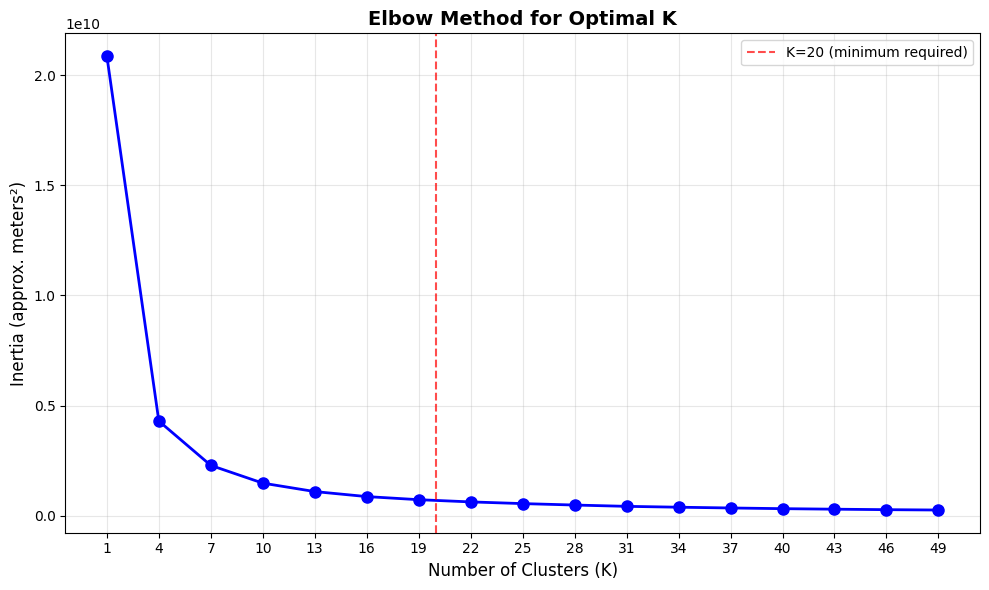

In [5]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# CONVERT LAT/LON TO APPROXIMATE METERS

lat = all_stations['start_station_latitude'].values
lon = all_stations['start_station_longitude'].values

# Approximate conversion for New York area (40.7°N)
# 1 degree latitude ≈ 111,000 meters
# 1 degree longitude ≈ 85,000 meters (at 40°N latitude)

lat_meters = lat * 111000  # meters
lon_meters = lon * 85000   # meters (adjusted for NYC latitude)

X_meters = np.column_stack([lat_meters, lon_meters])

print(f"Coordinate range:")
print(f"  Lat: {lat_meters.min():.0f} to {lat_meters.max():.0f} meters")
print(f"  Lon: {lon_meters.min():.0f} to {lon_meters.max():.0f} meters")

# ELBOW METHOD TO FIND OPTIMAL K

X = X_meters

k_values = range(1, 51, 3)
inertias = []

print("\nTesting different K values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=67, n_init=20)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.2e}")

# ============================================================================
# PLOT ELBOW CURVE
# ============================================================================

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (approx. meters²)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='K=20 (minimum required)')
plt.legend()

plt.tight_layout()
plt.savefig('elbow_plot_meters.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
kmeans = KMeans(n_clusters=20, random_state=67, n_init=20)
all_stations['cluster'] = kmeans.fit_predict(X_meters)

In [7]:
all_stations.head()

,start_station_id,start_station_latitude,start_station_longitude,cluster
0,72,40.767272,-73.993929,12
1324,79,40.719116,-74.006667,9
2430,82,40.711174,-74.000165,9
2865,83,40.683826,-73.976323,17
3550,119,40.696089,-73.978034,17


In [8]:
station_to_cluster = dict(zip(
    all_stations['start_station_id'], 
    all_stations['cluster']
))

# Add to df1
df1['start_cluster'] = df1['start_station_id'].map(station_to_cluster)
df1['end_cluster'] = df1['end_station_id'].map(station_to_cluster)

# Verify
print(f"\nMissing start clusters: {df1['start_cluster'].isna().sum()}")
print(f"Missing end clusters: {df1['end_cluster'].isna().sum()}")

df1.head()


Missing start clusters: 0
Missing end clusters: 0


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,...,1992,1,970.752,2018-01-01,13,Monday,1,1,12,16
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,...,1969,1,723.159,2018-01-01,15,Monday,1,1,12,16
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,...,1956,1,496.835,2018-01-01,15,Monday,1,1,12,12
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,...,1974,1,306.819,2018-01-01,15,Monday,1,1,12,12
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,...,1992,1,306.074,2018-01-01,18,Monday,1,1,12,1


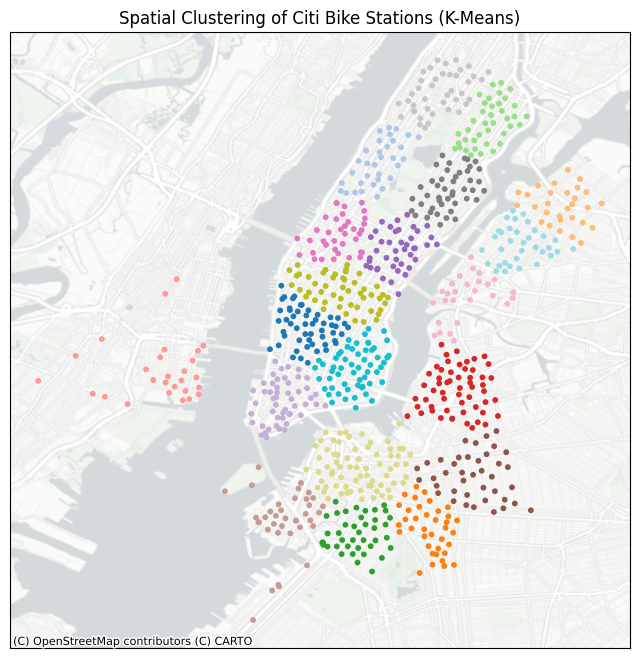

In [9]:
import contextily as cx

all_stations['cluster'].value_counts().sort_index()

fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(all_stations['start_station_longitude'], all_stations['start_station_latitude'], c=all_stations['cluster'], cmap='tab20', s=10)
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')
ax.set_title('Spatial Clustering of Citi Bike Stations (K-Means)')
ax.set_yticks([])
ax.set_xticks([])

cx.add_basemap(ax, zoom=12, crs="EPSG:4326",source=cx.providers.CartoDB.PositronNoLabels)
fig.savefig('station_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Task 2

In [10]:
# Selecting top and bottom cluster by pickup demand

cluster_demand = df1.groupby('start_cluster').size().sort_values(ascending=False)
largest_cluster_id = cluster_demand.idxmax()
smallest_cluster_id = cluster_demand.idxmin()
selected_clusters = [largest_cluster_id, smallest_cluster_id]

for cluster_id in selected_clusters:
    total_pickups = cluster_demand[cluster_id]
    num_stations = df1[df1['start_cluster'] == cluster_id]['start_station_id'].nunique()
    print(f"  Cluster {cluster_id}: {total_pickups:,} pickups, {num_stations} stations")




  Cluster 16: 2,546,906 pickups, 49 stations
  Cluster 3: 143,020 pickups, 29 stations


## Feature Helper Functions

In [11]:
# Feature Engineering Functions
import pandas as pd
import numpy as np

def aggregate_hourly_demand(df, cluster_id, target='pickups'):
    if target == 'pickups':
        cluster_trips = df[df['start_cluster'] == cluster_id].copy()
    else:
        cluster_trips = df[df['end_cluster'] == cluster_id].copy()
    
    cluster_trips['timestamp'] = pd.to_datetime(cluster_trips['date']) + pd.to_timedelta(cluster_trips['hour'], unit='h')
    hourly_counts = cluster_trips.groupby('timestamp').size().reset_index(name=target)
    hourly_counts = hourly_counts.set_index('timestamp').sort_index()
    
    full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
    hourly_counts = hourly_counts.reindex(full_range, fill_value=0)
    
    return hourly_counts

def add_time_features(hourly_data):
    df = hourly_data.copy()
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    # Assuming you have a 'day_of_week' column (0=Monday, 6=Sunday)
    df['is_rush_hour'] = (df['hour_of_day'].isin([7, 8, 9, 17, 18, 19]) & df['day_of_week'] < 5).astype(int)
    return df

def add_lag_features(hourly_data, target_col):
    df = hourly_data.copy()
    df['lag_1h'] = df[target_col].shift(1)
    df['lag_24h'] = df[target_col].shift(24)
    df['lag_168h'] = df[target_col].shift(168)
    return df

def add_rolling_features(hourly_data, target_col):
    df = hourly_data.copy()
    df['avg_last_3h'] = df[target_col].shift(1).rolling(window=3).mean()
    df['avg_last_24h'] = df[target_col].shift(1).rolling(window=24).mean()
    df['max_last_24h'] = df[target_col].shift(1).rolling(window=24).max()
    return df

def add_cyclical_features(hourly_data, target_col, train_cutoff='2018-10-31 23:59:59'):
    """
    Calculate only on training data.
    """
    df = hourly_data.copy()
    
    # Only use training data to calculate statistics
    train_data = df[df.index <= train_cutoff]
    
    # Hour of day stats
    hour_stats = train_data.groupby('hour_of_day')[target_col].mean()
    df['typical_hour_mean'] = df['hour_of_day'].map(hour_stats)
    
    # Day of week stats
    dow_stats = train_data.groupby('day_of_week')[target_col].mean()
    df['typical_dow_mean'] = df['day_of_week'].map(dow_stats)
    
    return df



## Complete Feature Function

In [12]:
def build_all_features(df, cluster_id, target='pickups'):
    hourly_data = aggregate_hourly_demand(df, cluster_id, target)
    hourly_data = add_time_features(hourly_data)
    hourly_data = add_lag_features(hourly_data, target)
    hourly_data = add_rolling_features(hourly_data, target)
    hourly_data = add_cyclical_features(hourly_data, target)
    hourly_data = hourly_data.dropna()
    return hourly_data

In [13]:
# Build features for all clusters
all_cluster_features = {}

for cluster_id in selected_clusters:
    pickups_features = build_all_features(df1, cluster_id, target='pickups')
    dropoffs_features = build_all_features(df1, cluster_id, target='dropoffs')
    
    all_cluster_features[cluster_id] = {
        'pickups': pickups_features,
        'dropoffs': dropoffs_features
    }
    
    print(f"Cluster {cluster_id}: {pickups_features.shape[0]} samples, {pickups_features.shape[1]} features")

/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_3087/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_3087/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 16: 8592 samples, 14 features


/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_3087/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_3087/3703792361.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 3: 8591 samples, 14 features


# Train / Test splits

In [14]:
# Train/test split
def split_time_series_data(ts_features, cutoff_date='2018-10-31 23:59:59', target='pickups'):
    feature_columns = [col for col in ts_features.columns if col not in [target]]
    
    train_mask = ts_features.index <= cutoff_date
    test_mask = ts_features.index > cutoff_date
    
    X_train = ts_features.loc[train_mask, feature_columns]
    y_train = ts_features.loc[train_mask, target]
    X_test = ts_features.loc[test_mask, feature_columns]
    y_test = ts_features.loc[test_mask, target]
    
    return X_train, X_test, y_train, y_test

# Metrics

In [15]:
def calculate_normalized_mae(y_true, y_pred):
    """MAE / Mean(y_true) - error as % of average demand"""
    mean_demand = np.mean(y_true)
    if mean_demand == 0:
        return np.nan
    mae = mean_absolute_error(y_true, y_pred)
    return (mae / mean_demand) * 100

def calculate_r2(y_true, y_pred):
    """Calculate R² score"""
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))


# Models (Baseline, Ridge and GB)

In [16]:
trained_models = {}


for cluster_id in selected_clusters:
    trained_models[cluster_id] = {'pickups': {}, 'dropoffs': {}}

    for target in ['pickups', 'dropoffs']:
        
        ts_data = all_cluster_features[cluster_id][target]
        X_train, X_test, y_train, y_test = split_time_series_data(ts_data, target=target)
        
        # Baseline: Last week
        baseline_pred_test = ts_data.loc[y_test.index, 'lag_168h'].values
        
        # Ridge Regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train_scaled, y_train)
        ridge_pred_test = np.maximum(ridge.predict(X_test_scaled), 0)
        
        
        # Gradient Boosting
        gb = GradientBoostingRegressor(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        )
        gb.fit(X_train, y_train)
        gb_pred_train = np.maximum(gb.predict(X_train), 0)
        gb_pred_test = np.maximum(gb.predict(X_test), 0)
        
        
        # Store models
        trained_models[cluster_id][target] = {
            'gb': gb,
            'ridge': ridge,
            'scaler': scaler,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'baseline_pred_test': baseline_pred_test,
            'ridge_pred_test': ridge_pred_test,
            'gb_pred_train': gb_pred_train,
            'gb_pred_test': gb_pred_test,
        }

# Hierarchical GB

In [18]:


# Collect GB predictions
all_X_hier_train = []
all_y_hier_pickups_train = []
all_y_hier_dropoffs_train = []
all_cluster_ids = []

for cluster_id in selected_clusters:
    gb_pred_train_pickups = trained_models[cluster_id]['pickups']['gb_pred_train']
    y_train_pickups = trained_models[cluster_id]['pickups']['y_train'].values
    
    gb_pred_train_dropoffs = trained_models[cluster_id]['dropoffs']['gb_pred_train']
    y_train_dropoffs = trained_models[cluster_id]['dropoffs']['y_train'].values
    
    n_samples = len(gb_pred_train_pickups)
    
    X_hier = np.column_stack([gb_pred_train_pickups, gb_pred_train_dropoffs])
    
    all_X_hier_train.append(X_hier)
    all_y_hier_pickups_train.append(y_train_pickups)
    all_y_hier_dropoffs_train.append(y_train_dropoffs)
    all_cluster_ids.append(np.full(n_samples, cluster_id))
    
 

X_hier_all = np.vstack(all_X_hier_train)
y_hier_pickups_all = np.hstack(all_y_hier_pickups_train)
y_hier_dropoffs_all = np.hstack(all_y_hier_dropoffs_train)
cluster_ids_all = np.hstack(all_cluster_ids)

# Normalize
scaler_hier_X = StandardScaler()
X_hier_all_scaled = scaler_hier_X.fit_transform(X_hier_all)

scaler_hier_pickups = StandardScaler()
scaler_hier_dropoffs = StandardScaler()
y_hier_pickups_scaled = scaler_hier_pickups.fit_transform(y_hier_pickups_all.reshape(-1, 1)).flatten()
y_hier_dropoffs_scaled = scaler_hier_dropoffs.fit_transform(y_hier_dropoffs_all.reshape(-1, 1)).flatten()

# Global hierarchical models
global_hier_pickups = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    alpha=0.001
)
global_hier_pickups.fit(X_hier_all_scaled, y_hier_pickups_scaled)

global_hier_dropoffs = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    alpha=0.001
)
global_hier_dropoffs.fit(X_hier_all_scaled, y_hier_dropoffs_scaled)

global_hier_pred_pickups = global_hier_pickups.predict(X_hier_all_scaled)
global_hier_pred_dropoffs = global_hier_dropoffs.predict(X_hier_all_scaled)

# Cluster-specific models
hierarchical_models = {}

for cluster_id in selected_clusters:
    mask = cluster_ids_all == cluster_id
    X_cluster = X_hier_all_scaled[mask]
    y_pickups_cluster = y_hier_pickups_scaled[mask]
    y_dropoffs_cluster = y_hier_dropoffs_scaled[mask]
    
    global_pred_pickups_cluster = global_hier_pred_pickups[mask]
    global_pred_dropoffs_cluster = global_hier_pred_dropoffs[mask]
    
    residuals_pickups = y_pickups_cluster - global_pred_pickups_cluster
    residuals_dropoffs = y_dropoffs_cluster - global_pred_dropoffs_cluster
    
    cluster_hier_pickups = MLPRegressor(
        hidden_layer_sizes=(16,),
        activation='relu',
        max_iter=200,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        alpha=0.001
    )
    cluster_hier_pickups.fit(X_cluster, residuals_pickups)
    
    cluster_hier_dropoffs = MLPRegressor(
        hidden_layer_sizes=(16,),
        activation='relu',
        max_iter=200,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        alpha=0.001
    )
    cluster_hier_dropoffs.fit(X_cluster, residuals_dropoffs)
    
    hierarchical_models[cluster_id] = {
        'pickups': cluster_hier_pickups,
        'dropoffs': cluster_hier_dropoffs
    }

# Store hierarchical models
for cluster_id in selected_clusters:
    trained_models[cluster_id]['hierarchical'] = {
        'global_pickups': global_hier_pickups,
        'global_dropoffs': global_hier_dropoffs,
        'cluster_pickups': hierarchical_models[cluster_id]['pickups'],
        'cluster_dropoffs': hierarchical_models[cluster_id]['dropoffs'],
        'scaler_X': scaler_hier_X,
        'scaler_pickups': scaler_hier_pickups,
        'scaler_dropoffs': scaler_hier_dropoffs,
    }

print("✓ Cluster-specific hierarchical models trained and stored")


# EVALUATE HIERARCHICAL LAYER ON TEST SET


print("\n" + "="*80)
print("EVALUATING HIERARCHICAL LAYER")
print("="*80)

for cluster_id in selected_clusters:
    gb_pred_test_pickups = trained_models[cluster_id]['pickups']['gb_pred_test']
    gb_pred_test_dropoffs = trained_models[cluster_id]['dropoffs']['gb_pred_test']
    
    X_hier_test = np.column_stack([gb_pred_test_pickups, gb_pred_test_dropoffs])
    X_hier_test_scaled = scaler_hier_X.transform(X_hier_test)
    
    global_hier_pred_test_pickups_scaled = trained_models[cluster_id]['hierarchical']['global_pickups'].predict(X_hier_test_scaled)
    global_hier_pred_test_dropoffs_scaled = trained_models[cluster_id]['hierarchical']['global_dropoffs'].predict(X_hier_test_scaled)
    
    cluster_hier_pred_test_pickups_scaled = trained_models[cluster_id]['hierarchical']['cluster_pickups'].predict(X_hier_test_scaled)
    cluster_hier_pred_test_dropoffs_scaled = trained_models[cluster_id]['hierarchical']['cluster_dropoffs'].predict(X_hier_test_scaled)
    
    hier_pred_test_pickups_scaled = global_hier_pred_test_pickups_scaled + cluster_hier_pred_test_pickups_scaled
    hier_pred_test_dropoffs_scaled = global_hier_pred_test_dropoffs_scaled + cluster_hier_pred_test_dropoffs_scaled
    
    hier_pred_test_pickups = scaler_hier_pickups.inverse_transform(hier_pred_test_pickups_scaled.reshape(-1, 1)).flatten()
    hier_pred_test_dropoffs = scaler_hier_dropoffs.inverse_transform(hier_pred_test_dropoffs_scaled.reshape(-1, 1)).flatten()
    
    hier_pred_test_pickups = np.maximum(hier_pred_test_pickups, 0)
    hier_pred_test_dropoffs = np.maximum(hier_pred_test_dropoffs, 0)
    
    trained_models[cluster_id]['pickups']['hier_pred_test'] = hier_pred_test_pickups
    trained_models[cluster_id]['dropoffs']['hier_pred_test'] = hier_pred_test_dropoffs

print("✓ Hierarchical predictions generated for all clusters")

✓ Cluster-specific hierarchical models trained and stored

EVALUATING HIERARCHICAL LAYER
✓ Hierarchical predictions generated for all clusters


# Show performance metrics

In [19]:

results = []

for cluster_id in selected_clusters:
    for target in ['pickups', 'dropoffs']:
        y_test = trained_models[cluster_id][target]['y_test'].values
        
        baseline_pred = trained_models[cluster_id][target]['baseline_pred_test']
        ridge_pred = trained_models[cluster_id][target]['ridge_pred_test']
        gb_pred = trained_models[cluster_id][target]['gb_pred_test']
        hgb_pred = trained_models[cluster_id][target]['hier_pred_test']
        
        for model_name, pred in [('Baseline', baseline_pred), 
                                  ('Ridge', ridge_pred), 
                                  ('GB', gb_pred), 
                                  ('HGB', hgb_pred)]:
            
            mae = mean_absolute_error(y_test, pred)
            norm_mae = calculate_normalized_mae(y_test, pred)
            r2 = calculate_r2(y_test, pred)
            
            results.append({
                'Cluster': cluster_id,
                'Model': model_name,
                'Target': target.capitalize(),
                'R²': r2,
                'MAE': mae,
                'Norm. MAE (%)': norm_mae
            })

results_df = pd.DataFrame(results)

# Print table
for target in ['Pickups', 'Dropoffs']:
    df = results_df[results_df['Target'] == target].copy()
    df = df[['Cluster', 'Model', 'R²', 'MAE', 'Norm. MAE (%)']].reset_index(drop=True)
    
    print(f"\n{target.upper()}")
    print("─" * 70)
    print(f"{'Cluster':<10}{'Model':<12}{'R²':<10}{'MAE':<12}{'Norm. MAE (%)':<15}")
    print("─" * 70)
    
    for _, row in df.iterrows():
        print(f"{int(row['Cluster']):<10}{row['Model']:<12}{row['R²']:<10.3f}"
              f"{row['MAE']:<12.2f}{row['Norm. MAE (%)']:<15.2f}")


PICKUPS
──────────────────────────────────────────────────────────────────────
Cluster   Model       R²        MAE         Norm. MAE (%)  
──────────────────────────────────────────────────────────────────────
16        Baseline    0.488     92.41       38.91          
16        Ridge       0.815     64.71       27.24          
16        GB          0.946     31.48       13.25          
16        HGB         0.948     30.52       12.85          
3         Baseline    0.218     5.77        52.82          
3         Ridge       0.627     4.17        38.16          
3         GB          0.703     3.81        34.90          
3         HGB         0.704     3.80        34.82          

DROPOFFS
──────────────────────────────────────────────────────────────────────
Cluster   Model       R²        MAE         Norm. MAE (%)  
──────────────────────────────────────────────────────────────────────
16        Baseline    0.511     93.01       38.81          
16        Ridge       0.818     66.22

# Task 3

# Calculatig Netflow and allocation need

In [24]:
actual_test_data = {}

for cluster_id in sorted(trained_models.keys()):
    y_test_pickups = trained_models[cluster_id]['pickups']['y_test']
    y_test_dropoffs = trained_models[cluster_id]['dropoffs']['y_test']
    
    actual_test_data[cluster_id] = {
        'dates': y_test_pickups.index,
        'pickups': y_test_pickups.values,
        'dropoffs': y_test_dropoffs.values,
        'predictions_pickups': trained_models[cluster_id]['pickups']['hier_pred_test'],
        'predictions_dropoffs': trained_models[cluster_id]['dropoffs']['hier_pred_test']
    }

# Analysis functions
def analyze_day_repositioning(day_index, cluster_ids=None):
    """Analyze bike repositioning for a specific day"""
    
    if cluster_ids is None:
        cluster_ids = sorted(trained_models.keys())
    
    sample_dates = actual_test_data[cluster_ids[0]]['dates']
    day_date = sample_dates[day_index * 24]
    day_str = day_date.strftime("%Y-%m-%d")
    
    analysis_results = {}
    
    print(f"\n{'='*80}")
    print(f"ANALYSIS FOR: {day_str}")
    print(f"{'='*80}")
    
    for cluster_id in cluster_ids:
        start_idx = day_index * 24
        end_idx = start_idx + 24
        
        pred_pickups = actual_test_data[cluster_id]['predictions_pickups'][start_idx:end_idx]
        pred_dropoffs = actual_test_data[cluster_id]['predictions_dropoffs'][start_idx:end_idx]
        
        actual_pickups = actual_test_data[cluster_id]['pickups'][start_idx:end_idx]
        actual_dropoffs = actual_test_data[cluster_id]['dropoffs'][start_idx:end_idx]
        
        # Calculate net flows (arrivals - departures)
        pred_net_flow = pred_dropoffs - pred_pickups
        actual_net_flow = actual_dropoffs - actual_pickups
        
        # Calculate cumulative flows
        pred_cumulative = np.cumsum(pred_net_flow)
        actual_cumulative = np.cumsum(actual_net_flow)
        
        # Calculate max deficits
        pred_max_deficit = abs(min(pred_cumulative)) if min(pred_cumulative) < 0 else 0
        actual_max_deficit = abs(min(actual_cumulative)) if min(actual_cumulative) < 0 else 0
        
        analysis_results[cluster_id] = {
            'date': day_str,
            'pred_pickups': pred_pickups,
            'pred_dropoffs': pred_dropoffs,
            'actual_pickups': actual_pickups,
            'actual_dropoffs': actual_dropoffs,
            'pred_net_flow': pred_net_flow,
            'actual_net_flow': actual_net_flow,
            'pred_cumulative': pred_cumulative,
            'actual_cumulative': actual_cumulative,
            'pred_max_deficit': pred_max_deficit,
            'actual_max_deficit': actual_max_deficit,
            'hours': np.arange(24)
        }
    
    return analysis_results

def print_summary_table(analysis_results):
    """Print summary table of predicted vs actual deficits"""
    
    print(f"\n{'='*80}")
    print("SUMMARY: BIKE ALLOCATION REQUIREMENTS (PREDICTED VS ACTUAL)")
    print(f"{'='*80}\n")
    
    summary_data = []
    
    for cluster_id in sorted(analysis_results.keys()):
        data = analysis_results[cluster_id]
        pred_deficit = data['pred_max_deficit']
        actual_deficit = data['actual_max_deficit']
        difference = actual_deficit - pred_deficit
        
        summary_data.append({
            'Cluster': cluster_id,
            'Predicted': int(pred_deficit),
            'Actual': int(actual_deficit),
            'Difference': int(difference),
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    print(f"\n{'─'*80}")
    print("Legend:")
    print("  Predicted: Bikes needed based on HGB predictions")
    print("  Actual: Bikes needed based on real demand")
    print("  Difference: Actual - Predicted (positive = underestimate)")




# Visualization

In [25]:
def plot_hourly_netflow(analysis_results, cluster_ids=None, figsize=(18, 10)):
    """
    Create comprehensive hourly flow visualization for bike repositioning
    
    Creates 3 plots per cluster:
    1. Stacked bar chart: Pickups vs Dropoffs by hour
    2. Net flow per hour: Green (surplus) vs Red (deficit)
    3. Cumulative balance: Shows running deficit/surplus with annotation
    
    Args:
        analysis_results: dict from analyze_day_repositioning()
        cluster_ids: list of cluster IDs to plot (None = all)
        figsize: figure size tuple
    """
    
    if cluster_ids is None:
        cluster_ids = sorted(analysis_results.keys())
    
    day_str = analysis_results[cluster_ids[0]]['date']
    
    # Create subplots: len(cluster_ids) rows × 3 columns
    fig, axes = plt.subplots(len(cluster_ids), 3, figsize=(figsize[0], 5*len(cluster_ids)))
    
    if len(cluster_ids) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, cluster_id in enumerate(cluster_ids):
        data = analysis_results[cluster_id]
        hours = data['hours']
        
        # ===== PLOT 1: Arrivals vs Departures (Stacked Bar Chart) =====
        ax = axes[idx, 0]
        width = 0.8
        
        # Red bars: Pickups (departures)
        ax.bar(hours, data['pred_pickups'], width, label='Pickups (Departures)', 
               color='red', alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Green bars stacked on top: Dropoffs (arrivals)
        ax.bar(hours, data['pred_dropoffs'], width, bottom=data['pred_pickups'],
               label='Dropoffs (Arrivals)', color='green', alpha=0.7, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
        ax.set_ylabel('Number of Bikes', fontsize=11, fontweight='bold')
        ax.set_title(f'Cluster {cluster_id}: Hourly Demand Pattern', fontsize=12, fontweight='bold')
        ax.set_xticks(hours[::2])
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        
        # ===== PLOT 2: Net Flow per Hour =====
        ax = axes[idx, 1]
        
        # Color code: green for surplus, red for deficit
        colors = ['green' if x > 0 else 'red' for x in data['pred_net_flow']]
        ax.bar(hours, data['pred_net_flow'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Horizontal line at zero
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        ax.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
        ax.set_ylabel('Net Flow (Arrivals - Departures)', fontsize=11, fontweight='bold')
        ax.set_title(f'Cluster {cluster_id}: Hourly Net Flow', fontsize=12, fontweight='bold')
        ax.set_xticks(hours[::2])
        ax.grid(True, alpha=0.3, axis='y')
        
        # ===== PLOT 3: Cumulative Balance (The Key Plot) =====
        ax = axes[idx, 2]
        
        # Plot cumulative line with color coding
        for i in range(len(hours)-1):
            color = 'green' if data['pred_cumulative'][i] >= 0 else 'red'
            ax.plot(hours[i:i+2], data['pred_cumulative'][i:i+2], 
                   color=color, linewidth=3, marker='o', markersize=6)
        
        # Horizontal dashed line at zero (break-even point)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        
        # Fill areas: surplus (green) and deficit (red)
        ax.fill_between(hours, data['pred_cumulative'], 0, 
                        where=(data['pred_cumulative'] >= 0),
                        color='green', alpha=0.2, label='Surplus')
        ax.fill_between(hours, data['pred_cumulative'], 0, 
                        where=(data['pred_cumulative'] < 0),
                        color='red', alpha=0.2, label='Deficit')
        
        ax.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
        ax.set_ylabel('Cumulative Balance', fontsize=11, fontweight='bold')
        ax.set_title(f'Cluster {cluster_id}: Cumulative Net Flow', fontsize=12, fontweight='bold')
        ax.set_xticks(hours[::2])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='upper left')
        
        # ===== ANNOTATE MAXIMUM DEFICIT =====
        worst_idx = np.argmin(data['pred_cumulative'])  # Find minimum (worst deficit)
        worst_val = data['pred_cumulative'][worst_idx]
        worst_hour = hours[worst_idx]
        
        # Plot red dot at worst point
        ax.scatter([worst_hour], [worst_val], color='red', s=200, zorder=5)
        
        # Add annotation with arrow
        ax.annotate(f'Max deficit:\n{worst_val:.0f} bikes',
                   xy=(worst_hour, worst_val),
                   xytext=(worst_hour + 3, worst_val - abs(worst_val)*0.3),
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8, edgecolor='black'),
                   arrowprops=dict(arrowstyle='->', lw=2, color='black'))
    
    # Overall title
    plt.suptitle(f'Task 3: Overnight Repositioning Strategy - {day_str}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()




# Plot 


ANALYSIS FOR: 2018-11-04

SUMMARY: BIKE ALLOCATION REQUIREMENTS (PREDICTED VS ACTUAL)

 Cluster  Predicted  Actual  Difference
       3         32      26          -6
      16         82     142          59

────────────────────────────────────────────────────────────────────────────────
Legend:
  Predicted: Bikes needed based on HGB predictions
  Actual: Bikes needed based on real demand
  Difference: Actual - Predicted (positive = underestimate)


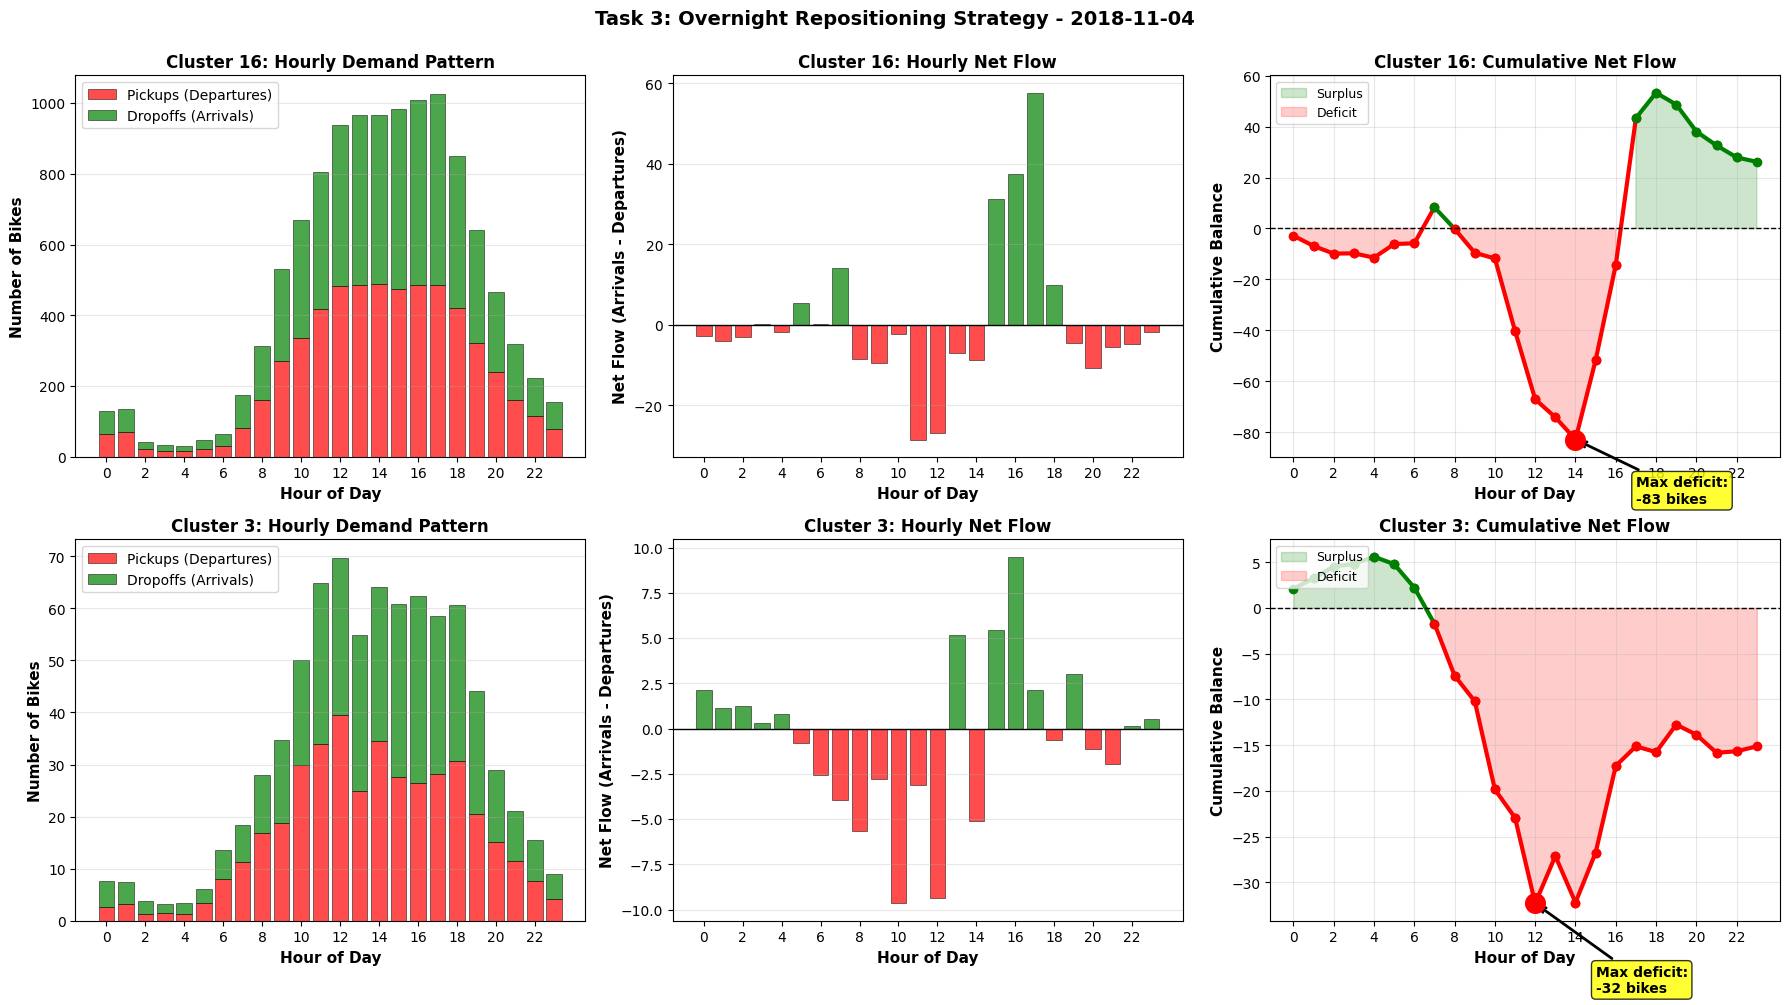

In [27]:
# Run analysis for November 2 (day_index=1)
DAY_INDEX = 3

results = analyze_day_repositioning(DAY_INDEX, cluster_ids=selected_clusters)
print_summary_table(results)

plot_hourly_netflow(results, cluster_ids=selected_clusters)